# ArtLine

### Turn your image into line art.

Original Author: [Vijish Madhavan](https://github.com/vijishmadhavan)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/vijishmadhavan/ArtLine

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/ArtLine.ipynb)

In [46]:
#@title Setup

!git clone https://github.com/vijishmadhavan/ArtLine.git ArtLine
%cd ArtLine
# !pip install -r colab_requirements.txt


import os
import numpy as np
from PIL import Image
from fastai.vision import nn, load_learner


class FeatureLoss(nn.Module):
  def __init__(self, m_feat, layer_ids, layer_wgts):
    super().__init__()
    self.m_feat = m_feat
    self.loss_features = [self.m_feat[i] for i in layer_ids]
    self.hooks = hook_outputs(self.loss_features, detach=False)
    self.wgts = layer_wgts
    self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
          ] + [f'gram_{i}' for i in range(len(layer_ids))]

  def make_features(self, x, clone=False):
    self.m_feat(x)
    return [(o.clone() if clone else o) for o in self.hooks.stored]
  
  def forward(self, input, target):
    out_feat = self.make_features(target, clone=True)
    in_feat = self.make_features(input)
    self.feat_losses = [base_loss(input,target)]
    self.feat_losses += [base_loss(f_in, f_out)*w
                          for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
    self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                          for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
    self.metrics = dict(zip(self.metric_names, self.feat_losses))
    return sum(self.feat_losses)
  
  def __del__(self):
    self.hooks.remove()


if not os.path.exists('ArtLine_920.pkl'):
  !wget "https://www.dropbox.com/s/04suaimdpru76h3/ArtLine_920.pkl?dl=1" -O ArtLine_920.pkl
if not os.path.exists('ArtLine_650.pkl'):
  !wget "https://www.dropbox.com/s/starqc9qd2e1lg1/ArtLine_650.pkl?dl=1" -O ArtLine_650.pkl


def add_margin(pil_img, top=250, right=250, bottom=250, left=250):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), (255, 255, 255))
    result.paste(pil_img, (left, top))
    return result


def tensor_to_img(tensor):
  arr = img_out.cpu().permute(1, 2, 0).numpy()
  arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))  # Normalize
  arr *= 255
  return Image.fromarray(arr.astype(np.uint8))


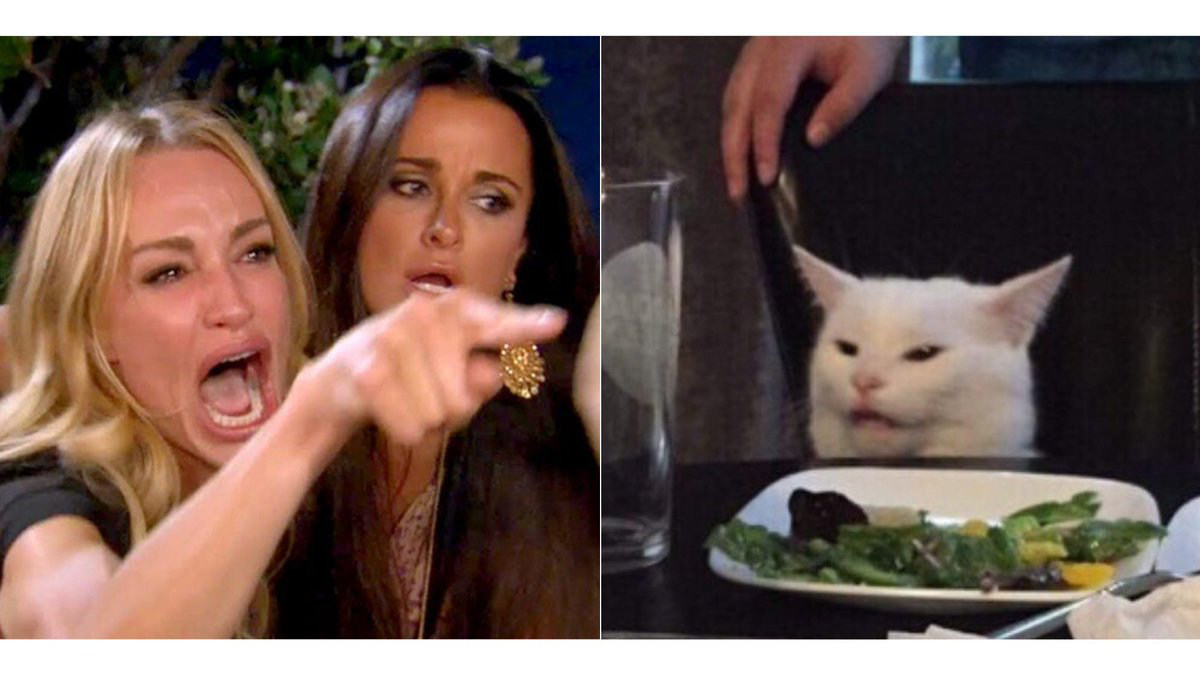

In [54]:
#@title Upload Image

from google.colab import files
from IPython.display import display
from PIL import Image


ff = files.upload()
img_name = list(ff.keys())[0]
img = Image.open(img_name).convert("RGB")
img_new = add_margin(img)
img_new.save(img_name)

display(img)

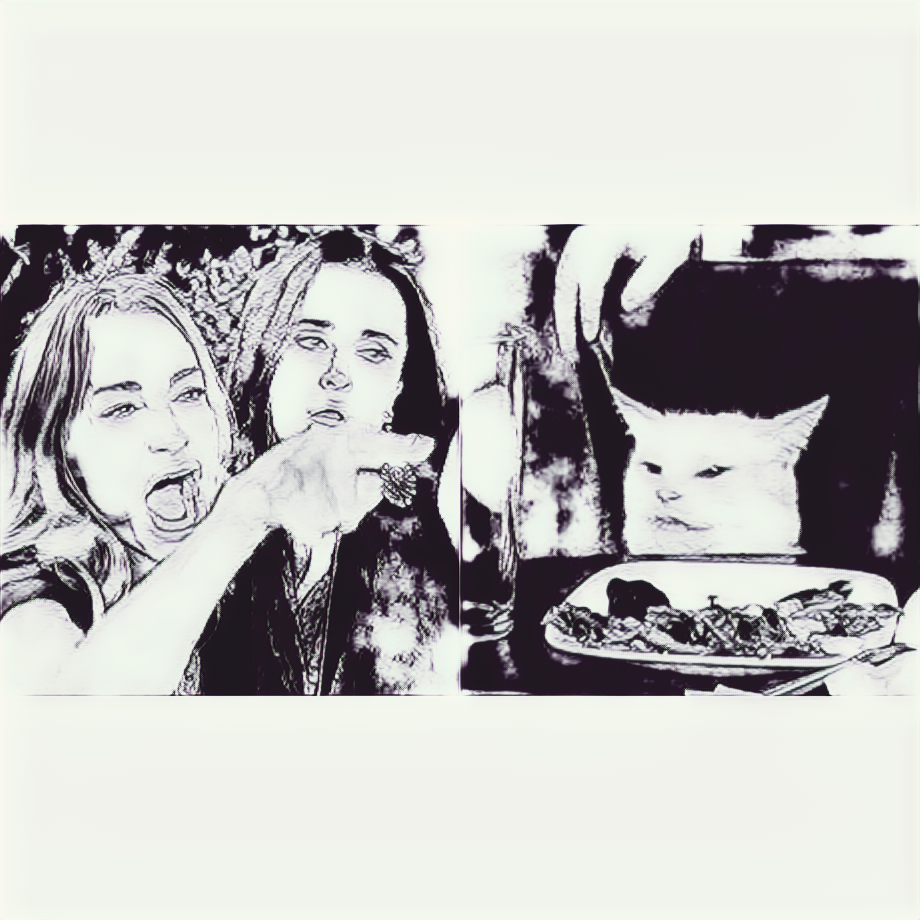

In [49]:
#@title Run

import numpy as np
from fastai.vision import open_image

mode = 'quality'  #@param['quality', 'smooth']
mode = {
    'quality': 'ArtLine_920.pkl',
    'smooth': 'ArtLine_650.pkl'
}[mode]

feature = open_image(img_name)
learner = load_learner('./', mode)
_, img_out, _ = learner.predict(feature)
img = tensor_to_img(img_out)
display(img)